In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*encountered in matmul")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    Lasso,
    LassoCV,
    LinearRegression,
    LogisticRegression,
    Ridge,
    RidgeCV
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    StratifiedKFold,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [3]:
# Section 1A

df = pd.read_csv("q1.csv")

# Target and features
y = df["CO(GT)"]
X = df.drop(columns=["CO(GT)"])


missing_Val = pd.DataFrame({
    "feature": X.columns,
    "num_NaN": X.isna().sum().values,
    "percent_NaN": ((X.isna().sum() / len(X) * 100).round(2).astype(str) + "%").values
})
print(missing_Val)

imputer = KNNImputer(n_neighbors=5)
X_imputed_array = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns)

          feature  num_NaN percent_NaN
0     PT08.S1(CO)      330        4.3%
1        C6H6(GT)      330        4.3%
2   PT08.S2(NMHC)      330        4.3%
3         NOx(GT)      413       5.38%
4    PT08.S3(NOx)      330        4.3%
5         NO2(GT)      416       5.42%
6    PT08.S4(NO2)      330        4.3%
7     PT08.S5(O3)      330        4.3%
8               T      330        4.3%
9              RH      330        4.3%
10             AH      330        4.3%


The table above shows that all features, aside from the target C0(GT), contain missing values roughly between 4 to 5 percent, with NOx(GT) and NO2(GT) having the highest missing value rate at approximately 5.4%. To address this, I used KNN imputation with k = 5. This method imputes missing entries by finding the five most similar observations in the dataset and estimating values based on their weighted distances. KNN is suitable for this dataset because the sensor readings and environmental variables are strongly correlated, and KNN preserves these multivariate relationships. It also handles non-linear interactions between variables, which are common in atmospheric and electrochemical sensor data.
I avoided using mean or median imputation because these methods replace missing values with a single constant, making the data look more uniform than it truly is and can distort the true pattern of the sensor readings. This is particularly undesirable for air-quality data, where measurements fluctuate with environmental conditions. KNN, by contrast, produces realistic imputations that maintain the structure of the data and support more accurate downstream regression modelling.

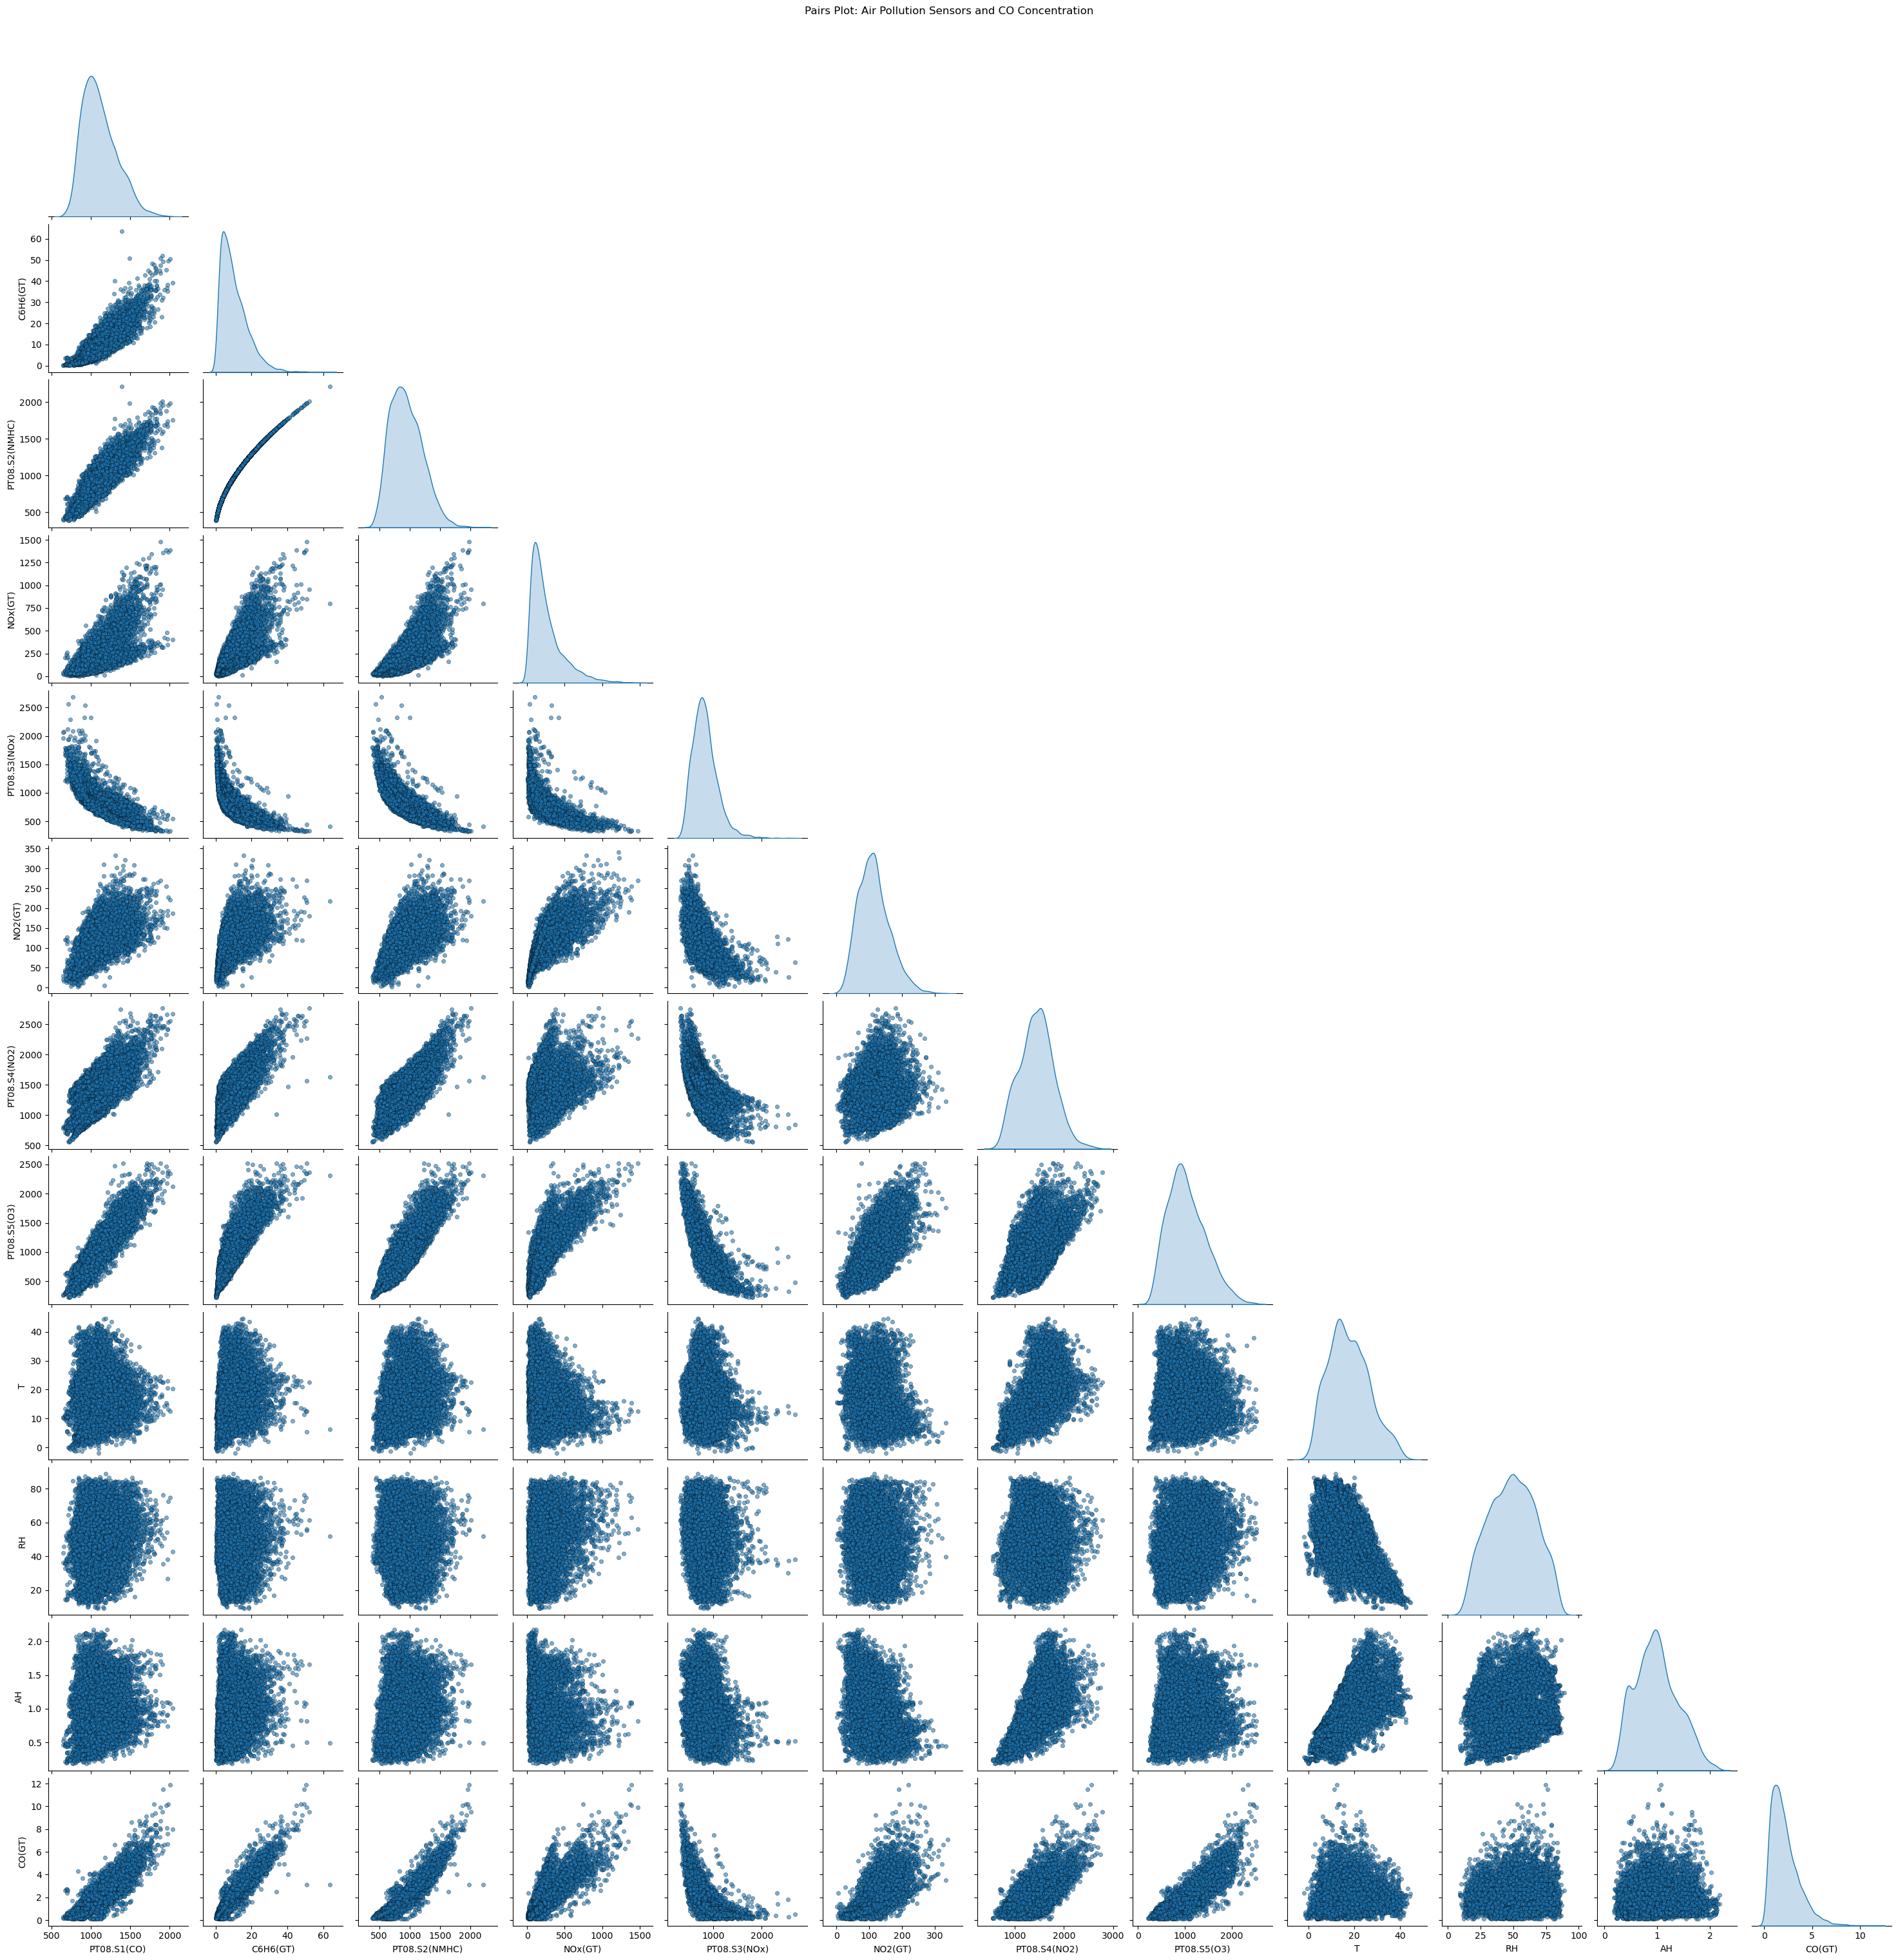

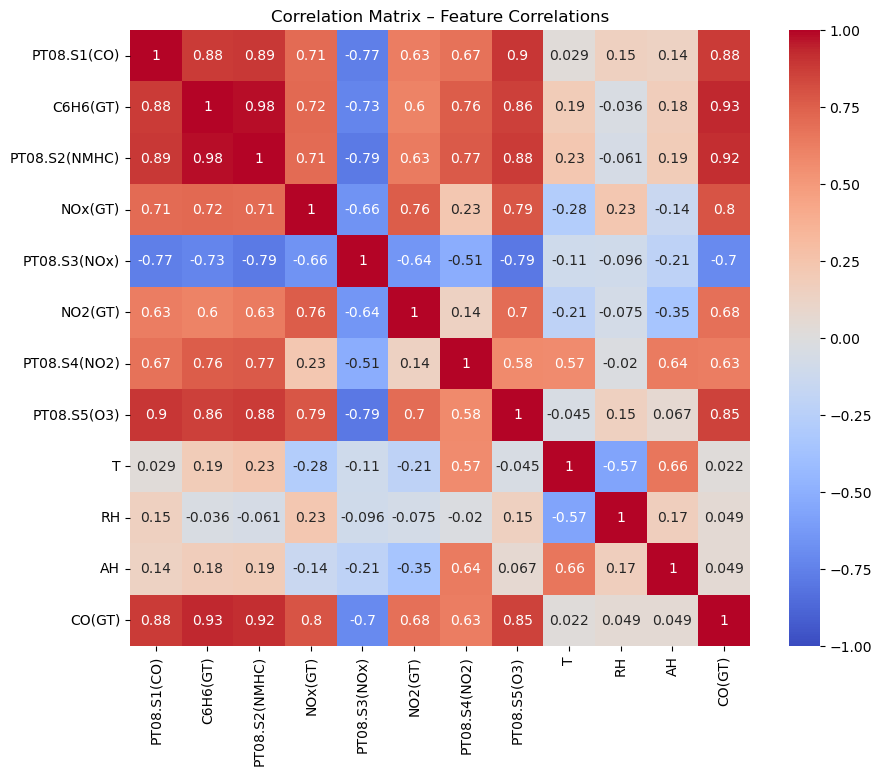

In [6]:
#Section 1B

df_plot = X.copy()
df_plot["CO(GT)"] = y
sns.pairplot( # Pairs Plot
    df_plot,
    diag_kind="kde",
    plot_kws={"alpha":0.6, "s":20, "edgecolor":"k"},
    corner=True
)

plt.suptitle("Pairs Plot: Air Pollution Sensors and CO Concentration", 
             y=1.02)
plt.show()

plt.figure(figsize=(10, 8)) # Correlation Matrix
corr = df_plot.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix – Feature Correlations")
plt.show()

The pair plot illustrates how each sensor and environmental variable relates to the other feature, in particular the bottom row highlights the relationship between the features and the target C0(GT). Several sensors show strong positive relationships with CO(GT), particularly PT08.S1(CO), C6H6(GT), PT08.S2(NOx), and PT08.S5(03) where higher sensor readings correspond to higher CO levels. Other sensors, such as NO2(GT), PT08.S4(NO2) and NOx(GT), show moderate but still noticeable upward patterns. On the other hand PT08.S3(NOx) shows a clear negative correlation with the target. Furthermore, environmental variables like temperature, relative humidity, and absolute humidity display little direct correlation with CO(GT), appearing as more diffuse clouds in the plot. Overall, the pair plot suggests that a subset of the gas sensors carries most of the predictive information needed to estimate CO concentration.
The correlation matrix also highlights how strongly many of the sensors correlate with one another, suggesting that several of them are capturing overlapping information and introducing potential multicollinearity in the dataset. In particular, PT08.S1(CO), C6H6(GT), PT08.S2(NMHC), and PT08.S5(O3) all show strong mutual correlations as well as strong correlations with CO(GT), confirming that multiple sensors capture similar underlying information.

In [9]:
#Section 1C

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.20, random_state=42
)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_sm = sm.OLS(y_train, X_train_sm).fit()
print(ols_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 CO(GT)   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     5147.
Date:                Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:01:27   Log-Likelihood:                -3873.4
No. Observations:                6139   AIC:                             7771.
Df Residuals:                    6127   BIC:                             7852.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1047      0.143     -7.746

The OLS regression model achieves an R² of 0.902, meaning it explains around 90.2 percent of the variation in CO(GT). This indicates a strong linear relationship between the sensor readings and the true CO concentration. The model captures most of the structure in the data, showing that the available sensors collectively provide good predictive power. The high condition number (6.18e+04), however, also suggests the presence of strong multicollinearity, which means that while prediction accuracy is high, individual coefficient values should be interpreted with caution.

Looking at the p-values, almost all sensors remain statistically significant predictors of CO(GT). In particular, PT08.S1(CO), C6H6(GT), NOx(GT), NO2(GT), PT08.S4(NO2), T, RH, PT08.S3(NOx), and PT08.S5(O3) all have p-values equal to or extremely close to 0, indicating they contribute meaningfully to the model. However, PT08.S2(NMHC) and AH have large p-values (above 0.30), suggesting they do not add significant information and may be redundant in the presence of other correlated sensors. Removing these variables would likely simplify the model without reducing performance.

Additionally, the coefficient values provide information about the relationship between the sensors and CO (GT). Positive coefficients, such as those for PT08.S1(CO), C6H6(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), and NOx(GT), imply that greater values from these sensors are connected with higher CO concentrations. On the other hand, numerous features exhibit negative coefficients, including PT08.S2(NMHC), PT08.S5(O3), T, RH, and AH. These negative values develop because several sensors are closely associated with each other, as seen in the pair plot. When many features overlap in the information they give, the regression model adjusts some coefficients downward to avoid double-counting the shared signal. This is due to both atmospheric dynamics and the way OLS allocates weight among correlated variables; it does not necessarily imply that these factors lower CO.

Overall, the model performs well, identifies the most relevant sensors, and highlights where multicollinearity influences coefficient behaviour. A regularised model, such as Ridge or Lasso, could further stabilise coefficient magnitudes and offer improved interpretability in the presence of such strong collinearity.

Best Ridge alpha: 9.437878277775392
Best Lasso alpha: 0.0008026433522257174


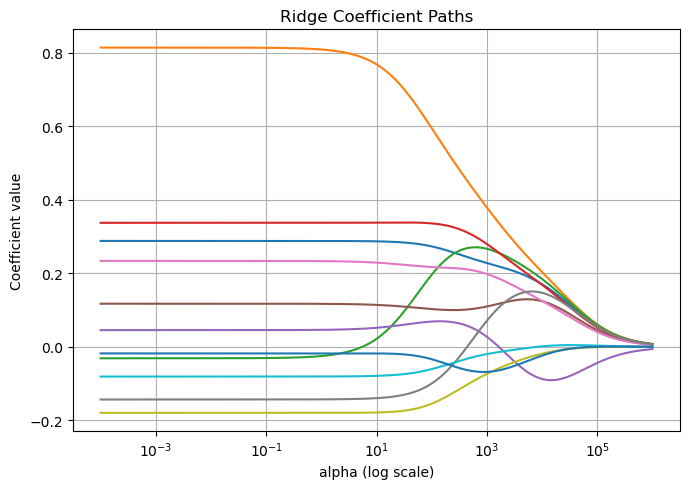

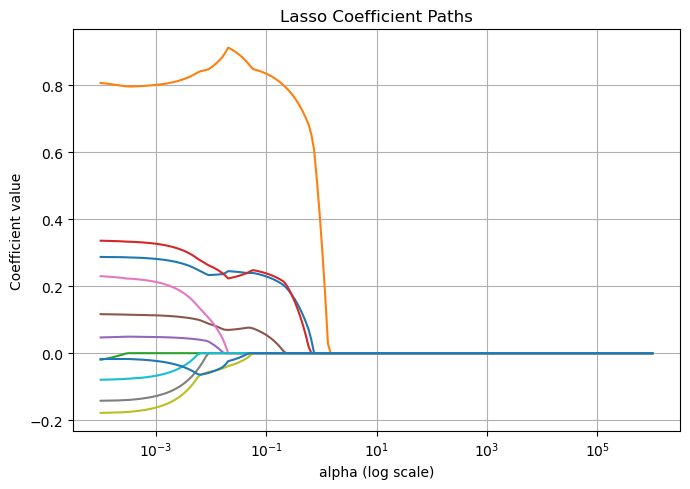

In [12]:
#Section 1D

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

reg_alphas = np.logspace(-4, 6, 200)

ridge_cv = RidgeCV(alphas=reg_alphas, cv=5) # Cross-validated Ridge
ridge_cv.fit(X_train_scaled, y_train)
best_ridge_alpha = ridge_cv.alpha_
print("Best Ridge alpha:", best_ridge_alpha)

lasso_cv = LassoCV(alphas=reg_alphas, cv=5, max_iter=20000,
                   random_state=0)
lasso_cv.fit(X_train_scaled, y_train)
best_lasso_alpha = lasso_cv.alpha_
print("Best Lasso alpha:", best_lasso_alpha)

ridge_coefs = [] # Compute coefficient paths
lasso_coefs = []

for alpha in reg_alphas:
    r = Ridge(alpha=alpha)
    r.fit(X_train_scaled, y_train)
    ridge_coefs.append(r.coef_)

    l = Lasso(alpha=alpha, max_iter=20000)
    l.fit(X_train_scaled, y_train)
    lasso_coefs.append(l.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(7, 5)) # Plot Ridge coefficient paths
for i in range(ridge_coefs.shape[1]):
    plt.plot(reg_alphas, ridge_coefs[:, i])
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 5)) # Plot Lasso coefficient paths
for i in range(lasso_coefs.shape[1]):
    plt.plot(reg_alphas, lasso_coefs[:, i])
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Paths")
plt.grid(True)
plt.tight_layout()
plt.show()

The coefficient path graphs show how each model reacts as the regularisation strength increases. For Ridge, the coefficients gradually shrink towards zero as alpha reaches large values. Since Ridge keeps all features, it reduces the impact of multicollinearity by shrinking all coefficients toward zero. It does not force any weights to become exactly zero, but it pulls large weights down and stabilises the model by spreading the penalty across all features. Using the RidgeCV function, the best alpha was found to be about 9.43. This level of shrinkage improves the model by controlling the effects of multicollinearity while still keeping the important signals strong. For Lasso, many coefficients drop exactly to zero as alpha increases because Lasso performs feature selection as part of the regularisation process. Using the LassoCV function, the optimal alpha was found to be about 0.0008, which keeps only the most important sensors active while removing redundant ones. Overall, Ridge stabilises the model, while Lasso simplifies it by selecting a smaller subset of meaningful features.

In [14]:
#Section 1E

def evaluate_krr(kernel, param_grid):

    pipe = Pipeline([     # Pipeline set up
        ("scaler", StandardScaler()),
        ("krr", KernelRidge(kernel=kernel))
    ])


    cv = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
    
    grid = {"krr__alpha": param_grid.get("alpha", [1.0])}
    for k, v in param_grid.items():
        if k != "alpha":
            grid[f"krr__{k}"] = v

    g = GridSearchCV(     # Grid search
        pipe,
        param_grid=grid,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=None
    )
    
    g.fit(X_train, y_train) # fit on training data
    best = g.best_estimator_ # best model and predictions
    ytr = best.predict(X_train)
    yte = best.predict(X_test)
    
    return {
        "y_pred_test": yte,
        "best_params": g.best_params_,
        "train_rmse": rmse(y_train, ytr),
        "test_rmse": rmse(y_test, yte),
        "test_r2": r2_score(y_test, yte),
        "best_estimator": best
    }

res_poly_deg2 = evaluate_krr( #Ploynomial KRR degree 2
    "polynomial",
    {
        "alpha": [0.01, 0.1, 1.0, 10.0],
        "degree": [2],
        "coef0": [0, 1]
    }
)


# Plot for comparison
y_pred_train_ols = ols_sm.predict(X_train_sm)
y_pred_test_ols = ols_sm.predict(X_test_sm)

ols_train_rmse = rmse(y_train, y_pred_train_ols)
ols_test_rmse = rmse(y_test, y_pred_test_ols)
ols_test_r2 = r2_score(y_test, y_pred_test_ols)


y_pred_train_ridge = ridge_cv.predict(X_train_scaled)
y_pred_test_ridge = ridge_cv.predict(X_test_scaled)

ridge_train_rmse = rmse(y_train, y_pred_train_ridge)
ridge_test_rmse = rmse(y_test, y_pred_test_ridge)
ridge_test_r2 = r2_score(y_test, y_pred_test_ridge)

y_pred_train_lasso = lasso_cv.predict(X_train_scaled)
y_pred_test_lasso = lasso_cv.predict(X_test_scaled)

lasso_train_rmse = rmse(y_train, y_pred_train_lasso)
lasso_test_rmse = rmse(y_test, y_pred_test_lasso)
lasso_test_r2 = r2_score(y_test, y_pred_test_lasso)

print("MODEL PERFORMANCE COMPARISON")

print("OLS:")
print(f"  Train RMSE = {ols_train_rmse:.3f}")
print(f"  Test RMSE  = {ols_test_rmse:.3f}")
print(f"  Test R²    = {ols_test_r2:.3f}\n")

print("Ridge:")
print(f"  Train RMSE = {ridge_train_rmse:.3f}")
print(f"  Test RMSE  = {ridge_test_rmse:.3f}")
print(f"  Test R²    = {ridge_test_r2:.3f}\n")

print("Lasso:")
print(f"  Train RMSE = {lasso_train_rmse:.3f}")
print(f"  Test RMSE  = {lasso_test_rmse:.3f}")
print(f"  Test R²    = {lasso_test_r2:.3f}\n")

print("Poly KRR (deg=2):")
print(f"  Train RMSE = {res_poly_deg2['train_rmse']:.3f}")
print(f"  Test RMSE  = {res_poly_deg2['test_rmse']:.3f}")
print(f"  Test R²    = {res_poly_deg2['test_r2']:.3f}")

MODEL PERFORMANCE COMPARISON
OLS:
  Train RMSE = 0.455
  Test RMSE  = 0.442
  Test R²    = 0.906

Ridge:
  Train RMSE = 0.455
  Test RMSE  = 0.443
  Test R²    = 0.906

Lasso:
  Train RMSE = 0.455
  Test RMSE  = 0.442
  Test R²    = 0.906

Poly KRR (deg=2):
  Train RMSE = 0.423
  Test RMSE  = 0.417
  Test R²    = 0.917


The polynomial kernel ridge model gives a lower test RMSE of 0.417 and a higher test R² of 0.917 compared to OLS, Ridge, and Lasso, which all achieve a test RMSE of around 0.442 and a test R² of about 0.906. This means the polynomial model reduces prediction error by roughly 6% and captures an extra 1.1% of the variance in CO(GT), which is an improvement given that all three linear models perform almost identically. The linear methods also have identical training RMSE values (0.455), showing that they reach the same performance plateau because they are restricted to straight-line relationships. In contrast, the polynomial model reaches a lower training RMSE of 0.423, indicating that it captures the underlying patterns in the data more effectively.

The improvement occurs because the degree-2 polynomial kernel can capture non-linear relationships between the sensors and CO(GT) that linear models cannot represent. Linear models can only learn straight-line patterns, so they struggle when the data is not linearly separable. A polynomial kernel maps the data into a higher-dimensional space where curved or non-linear patterns become easier for the model to fit. The pair plot revealed several non-linear relationships between the sensors and CO(GT), and the polynomial model is better equipped to learn these. As a result, the degree-2 kernel ridge model provides a more accurate and flexible fit while still using regularisation to prevent overfitting.

In [17]:
#Section 1F
res_rbf = evaluate_krr("rbf", {"alpha":[0.01,0.1,1.0], 
                               "gamma":[0.001,0.01,0.1,1.0]})
print("RBF KRR:")
print(f"  Best params : {res_rbf['best_params']}")
print(f"  Test RMSE   : {round(res_rbf['test_rmse'], 3)}")
print(f"  Test R²     : {round(res_rbf['test_r2'], 3)}")

RBF KRR:
  Best params : {'krr__alpha': 0.01, 'krr__gamma': 0.1}
  Test RMSE   : 0.374
  Test R²     : 0.933


In [19]:
# Section 1G

# Predictions
y_pred_train_ols   = ols_sm.predict(X_train_sm)
y_pred_test_ols    = ols_sm.predict(X_test_sm)
y_pred_train_ridge = ridge_cv.predict(X_train_scaled)
y_pred_test_ridge  = ridge_cv.predict(X_test_scaled)
y_pred_train_lasso = lasso_cv.predict(X_train_scaled)
y_pred_test_lasso  = lasso_cv.predict(X_test_scaled)
y_pred_train_poly  = res_poly_deg2["best_estimator"].predict(X_train)
y_pred_test_poly   = res_poly_deg2["y_pred_test"]
y_pred_train_rbf   = res_rbf["best_estimator"].predict(X_train)
y_pred_test_rbf    = res_rbf["y_pred_test"]


pd.set_option("display.float_format", "{:.3f}".format)

results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "Lasso", "Poly KRR (deg=2)", "RBF KRR"],
    "Train R2": [
        r2_score(y_train, y_pred_train_ols),
        r2_score(y_train, y_pred_train_ridge),
        r2_score(y_train, y_pred_train_lasso),
        r2_score(y_train, y_pred_train_poly),
        r2_score(y_train, y_pred_train_rbf),
    ],
    "Train RMSE": [
        rmse(y_train, y_pred_train_ols),
        rmse(y_train, y_pred_train_ridge),
        rmse(y_train, y_pred_train_lasso),
        rmse(y_train, y_pred_train_poly),
        rmse(y_train, y_pred_train_rbf),
    ],
    "Train MAE": [
        mae(y_train, y_pred_train_ols),
        mae(y_train, y_pred_train_ridge),
        mae(y_train, y_pred_train_lasso),
        mae(y_train, y_pred_train_poly),
        mae(y_train, y_pred_train_rbf),
    ],
    "Test R2": [
        r2_score(y_test, y_pred_test_ols),
        r2_score(y_test, y_pred_test_ridge),
        r2_score(y_test, y_pred_test_lasso),
        r2_score(y_test, y_pred_test_poly),
        r2_score(y_test, y_pred_test_rbf),
    ],
    "Test RMSE": [
        rmse(y_test, y_pred_test_ols),
        rmse(y_test, y_pred_test_ridge),
        rmse(y_test, y_pred_test_lasso),
        rmse(y_test, y_pred_test_poly),
        rmse(y_test, y_pred_test_rbf),
    ],
    "Test MAE": [
        mae(y_test, y_pred_test_ols),
        mae(y_test, y_pred_test_ridge),
        mae(y_test, y_pred_test_lasso),
        mae(y_test, y_pred_test_poly),
        mae(y_test, y_pred_test_rbf),
    ],
})

display(results)

Model  Train R2  Train RMSE  Train MAE  Test R2  Test RMSE  \
0               OLS     0.902       0.455      0.281    0.906      0.442   
1             Ridge     0.902       0.455      0.282    0.906      0.443   
2             Lasso     0.902       0.455      0.281    0.906      0.442   
3  Poly KRR (deg=2)     0.915       0.423      0.263    0.917      0.417   
4           RBF KRR     0.950       0.324      0.203    0.933      0.374   

   Test MAE  
0     0.283  
1     0.284  
2     0.283  
3     0.263  
4     0.236

The three linear models, OLS, Ridge and Lasso, show nearly identical performance across all the metrics, with OLS achieving a test R² of 0.906, a test RMSE of 0.442, and a test MAE of 0.283, and both Ridge and Lasso performing nearly the same. This means that regularisation does not improve the predictive accuracy drastically for this dataset. The reason is that the relationship between the features and CO(GT) is mostly linear, so OLS already captures it effectively without requiring extra regularisation. Ridge and Lasso still offer advantages in coefficient stability and sparsity, but these do not translate into meaningful improvements in predictive performance.

Although Ridge and Lasso do not show much improvement in accuracy, they still impact the model structure. Ridge slightly stabilises the coefficients by driving them close to zero but not equal to zero, thereby reducing the effect of multicollinearity. Lasso goes further by shrinking some coefficients to zero, removing redundant sensors and producing a simpler model. However, because many sensors carry overlapping information, removing one or two does not significantly change the predictions.

The two non-linear models, polynomial kernel ridge (degree 2) and RBF kernel ridge, both outperform the linear models. This is expected because non-linear models can map the data into a higher-dimensional feature space, allowing them to capture curved or complex relationships that linear models can't. Linear models only fit straight-line patterns, and the pair plot showed that several sensor–CO(GT) relationships are non-linear, making kernel methods more ideal.

Compared to the linear models, both kernel models show clear improvements. The degree-2 polynomial kernel ridge model increases the test R² to 0.9166, reduces the RMSE to 0.4168, and lowers the MAE to 0.263. This shows roughly a 5.7% reduction in RMSE and a 1.0% increase in R² compared to the linear models. Even this simple second-degree expansion is enough to identify non-linear data that the linear models cannot represent.

Furthermore, the RBF kernel ridge model provides an even greater improvement. It achieves a test R² of 0.9327, a test RMSE of 0.3745, and a test MAE of 0.236. This corresponds to about a 15% reduction in RMSE and a 2.7% increase in R² over the linear models. The improvement comes from how flexible the RBF kernel is. Instead of relying on simple squared terms like a polynomial kernel, the RBF kernel can capture much more nuanced, smooth, and complex nonlinear relationships. In practice, this allows it to follow the underlying sensor behaviour far more closely, which translates into noticeably more accurate predictions.

Overall, the RBF kernel ridge model achieves the strongest predictive performance across all models. Its ability to learn complex non-linear relationships makes it the most accurate option for predicting CO(GT) in this dataset.

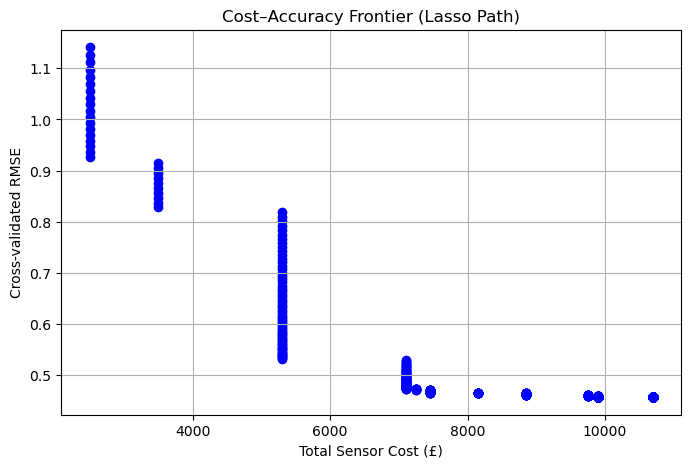

LOW-COST DESIGN (≤ £2500)
Alpha: 0.7453159674382293
Features selected: ['C6H6(GT)']
Total Cost: 2500
Test RMSE: 0.9231479348807978

HIGH-PERFORMANCE DESIGN (≤ £4000)
Alpha: 0.6269697076670071
Features selected: ['PT08.S1(CO)', 'C6H6(GT)']
Total Cost: 3500
Test RMSE: 0.8246347601839311


In [208]:
# Section 1H

sensor_costs = {
    "PT08.S1(CO)": 1000,
    "PT08.S2(NMHC)": 800,
    "PT08.S3(NOx)": 700,
    "PT08.S4(NO2)": 700,
    "PT08.S5(O3)": 900,
    "T": 150,
    "RH": 150,
    "AH": 200,
    "NOx(GT)": 1800,
    "NO2(GT)": 1800,
    "C6H6(GT)": 2500
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
alphas = np.logspace(-6, 0, 800)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
costs = []
rmses = []
selected_features = []

for alpha in alphas:
    l = Lasso(alpha=alpha, max_iter=50000)
    val_rmse = -np.mean( # CV RMSE 
        cross_val_score(
            l, X_train_scaled, y_train,
            scoring="neg_root_mean_squared_error",
            cv=cv
        )
    )

    rmses.append(val_rmse)

    l.fit(X_train_scaled, y_train) # Fit on full train set 
    coef_mask = l.coef_ != 0
    selected = X.columns[coef_mask]

    selected_features.append(list(selected))

    total = sum(sensor_costs[f] for f in selected)
    costs.append(total) # Total price of sensors chosen by the model

# Cost–accuracy trade-off plot
plt.figure(figsize=(8, 5))
plt.scatter(costs, rmses, c="blue")
plt.xlabel("Total Sensor Cost (£)")
plt.ylabel("Cross-validated RMSE")
plt.title("Cost–Accuracy Frontier (Lasso Path)")
plt.grid(True)
plt.show()

valid_rmse_low = [] #Low-Cost Design
for rmse_val, cost in zip(rmses, costs):
    valid_rmse_low.append(rmse_val if cost <= 2500 else np.inf)

low_cost_idx = np.argmin(valid_rmse_low)

low_cost_alpha = alphas[low_cost_idx]
low_cost_features = selected_features[low_cost_idx]
low_cost_total = costs[low_cost_idx]
low_cost_rmse_cv = rmses[low_cost_idx]


valid_rmse_high = [] # High-Performance Design
for rmse_val, cost in zip(rmses, costs):
    valid_rmse_high.append(rmse_val if cost <= 4000 else np.inf)

high_perf_idx = np.argmin(valid_rmse_high)

high_perf_alpha = alphas[high_perf_idx]
high_perf_features = selected_features[high_perf_idx]
high_perf_total = costs[high_perf_idx]
high_perf_rmse_cv = rmses[high_perf_idx]


l_low = Lasso(alpha=low_cost_alpha, max_iter=50000) 
l_low.fit(X_train_scaled, y_train) # Fit final Lasso models
y_low_pred = l_low.predict(X_test_scaled)
low_cost_rmse_test = rmse(y_test, y_low_pred)

l_high = Lasso(alpha=high_perf_alpha, max_iter=50000)
l_high.fit(X_train_scaled, y_train)
y_high_pred = l_high.predict(X_test_scaled)
high_perf_rmse_test = rmse(y_test, y_high_pred)

print("LOW-COST DESIGN (≤ £2500)") # Plot
print("Alpha:", low_cost_alpha)
print("Features selected:", low_cost_features)
print("Total Cost:", low_cost_total)
print("Test RMSE:", low_cost_rmse_test)

print("\nHIGH-PERFORMANCE DESIGN (≤ £4000)")
print("Alpha:", high_perf_alpha)
print("Features selected:", high_perf_features)
print("Total Cost:", high_perf_total)
print("Test RMSE:", high_perf_rmse_test)


The cost–accuracy frontier shows how predictive performance improves as more sensors are added through the Lasso path. At very low costs, the RMSE is high because the model is restricted to only one or two sensors. As total sensor cost increases, the RMSE drops sharply and then gradually levels off, indicating a plateau in performance. This pattern suggests that a few sensors provide most of the predictive power, while adding more sensors leads to limited improvements.

For the low-cost design (≤ £2500), the Lasso model selects only a single sensor: C6H6(GT). This setup is inexpensive, but the updated test RMSE of 0.9231 shows that relying on just one sensor limits the model’s ability to capture the variability in CO(GT).

The high-performance monitor (≤ £4000) includes two sensors: PT08.S1(CO) and C6H6(GT). Adding PT08.S1(CO) gives the model a second independent source of information, reducing the test RMSE to 0.8246. The high-performance model improves the test RMSE by roughly 11%, which is quite significant given that only one additional sensor is added. Although the improvement is not dramatic, small gains in accuracy can be important in practical air-quality applications, where better predictions reduce the likelihood of misclassifying pollution levels.

Overall, spending more on additional sensors does improve performance, but the marginal gains decrease as the total cost increases. For an extra £1000, the high-performance design achieves a meaningful reduction in error. However, the cost–accuracy frontier also indicates that the largest improvements occur when spending increases into the £5000–£8000 range, where multiple high-value sensors contribute to a much lower RMSE.

LOW-COST DESIGN
Features: ['C6H6(GT)']
Alpha: 0.745316
Best threshold t*: 3.144 mg/m³
Cross-validated expected cost: £140,000


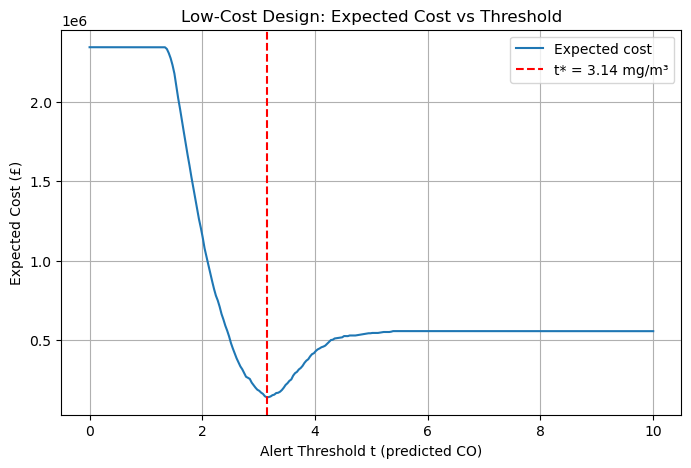

HIGH-PERFORMANCE DESIGN
Features: ['PT08.S1(CO)', 'C6H6(GT)']
Alpha: 0.626970
Best threshold t*: 3.344 mg/m³
Cross-validated expected cost: £137,200


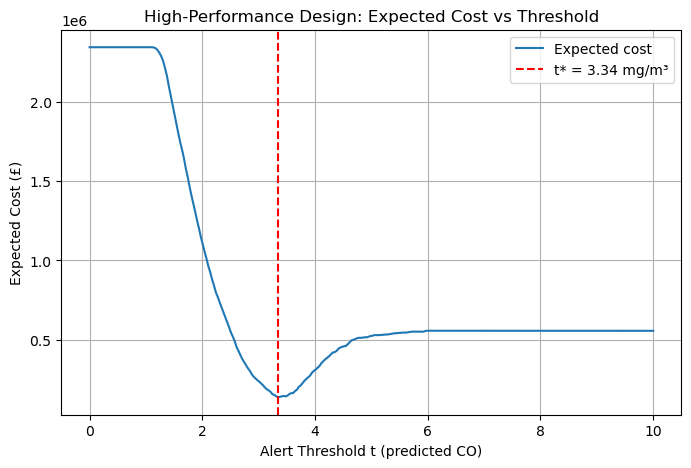

In [210]:
# Section 1I

LEGAL_LIMIT = 5.0 # mg/m³
thresholds = np.linspace(0, 10, 300)

def cost_curve_for_design(features, alpha, X_train, y_train):
    X_train_sub = X_train[features]   # restrict to the chosen sensors
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_costs = np.zeros(len(thresholds))

    for train_idx, val_idx in cv.split(X_train_sub):
        X_train_cv = X_train_sub.iloc[train_idx]     # fold train
        y_train_cv = y_train.iloc[train_idx]
        X_valid_cv = X_train_sub.iloc[val_idx]       # fold validation
        y_valid_cv = y_train.iloc[val_idx]

        scaler = StandardScaler()                    # scale inside fold
        X_train_cv_scaled = scaler.fit_transform(X_train_cv)
        X_valid_cv_scaled = scaler.transform(X_valid_cv)

        model = Lasso(alpha=alpha, max_iter=50000)   # fit Lasso on fold
        model.fit(X_train_cv_scaled, y_train_cv)

        y_pred = model.predict(X_valid_cv_scaled)    # predicted CO
        true_alert = (y_valid_cv.values > LEGAL_LIMIT)

        for i, t in enumerate(thresholds): # cost across thresholds
            pred_alert = (y_pred > t)
            FP = np.sum((pred_alert == 1) & (true_alert == 0))
            FN = np.sum((pred_alert == 0) & (true_alert == 1))
            cv_costs[i] += 2000 * FP + 10000 * FN    

    cv_costs /= cv.get_n_splits() # average across folds
    return cv_costs


cv_costs_low = cost_curve_for_design(low_cost_features, low_cost_alpha,
                                     X_train, y_train)
best_idx_low = np.argmin(cv_costs_low)
best_t_low = thresholds[best_idx_low] # best alert threshold
best_cost_low = cv_costs_low[best_idx_low]

print("LOW-COST DESIGN")
print("Features:", low_cost_features)
print(f"Alpha: {low_cost_alpha:.6f}")
print(f"Best threshold t*: {best_t_low:.3f} mg/m³")
print(f"Cross-validated expected cost: £{best_cost_low:,.0f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, cv_costs_low, label="Expected cost")
plt.axvline(best_t_low, color="red",
            linestyle="--", label=f"t* = {best_t_low:.2f} mg/m³")
plt.xlabel("Alert Threshold t (predicted CO)")
plt.ylabel("Expected Cost (£)")
plt.title("Low-Cost Design: Expected Cost vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


cv_costs_high = cost_curve_for_design(high_perf_features, 
                                      high_perf_alpha, X_train, y_train)
best_idx_high = np.argmin(cv_costs_high)
best_t_high = thresholds[best_idx_high] # best alert threshold
best_cost_high = cv_costs_high[best_idx_high]

print("HIGH-PERFORMANCE DESIGN")
print("Features:", high_perf_features)
print(f"Alpha: {high_perf_alpha:.6f}")
print(f"Best threshold t*: {best_t_high:.3f} mg/m³")
print(f"Cross-validated expected cost: £{best_cost_high:,.0f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, cv_costs_high, label="Expected cost")
plt.axvline(best_t_high, color="red", linestyle="--", 
            label=f"t* = {best_t_high:.2f} mg/m³")
plt.xlabel("Alert Threshold t (predicted CO)")
plt.ylabel("Expected Cost (£)")
plt.title("High-Performance Design: Expected Cost vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

Based on the expected-cost curves, the best alert threshold is when the value t minimises the expected cost. For the low-cost design, the optimal threshold is approximately 3.144 mg/m³, while for the high-performance design, it is approximately 3.344 mg/m³. In both cases, the optimal threshold is still lower than the legal limit of 5 mg/m³. This happens because false negatives carry a much higher penalty than false positives, so shifting the alert threshold downward reduces the chance of missing a dangerous pollution event. Therefore, an alert threshold of roughly 3.2–3.3 mg/m³ is a reasonable choice for issuing public health alerts in practice.

**Section 1J**

The expected-cost curves for both the low-cost and high-performance monitoring designs follow a similar U-shaped pattern. When the alert threshold t is very low, the expected cost becomes extremely high because the model issues too many alerts, resulting in a large number of false positives, each costing £2,000. As the threshold increases, the expected cost decreases sharply due to fewer unnecessary alerts. However, once the threshold becomes too high, the cost rises again because the model begins to miss dangerous pollution events. Since false negatives carry a far higher penalty (£10,000), they quickly dominate the overall cost when the threshold is set too aggressively. This U-shape clearly reflects the trade-off between the two types of errors.

For the low-cost design, which uses only the C6H6(GT) sensor, the minimum expected cost occurs at a threshold of t = 3.144 mg/m³, with an expected cost of £140,000. This threshold is below the legal limit of 5 mg/m³ because the model compensates for its limited accuracy by issuing alerts earlier. With only one sensor, predictions are less stable, so lowering the threshold helps avoid expensive false negatives, even though it increases the number of false positives.

For the high-performance design, which uses PT08.S1(CO) and C6H6(GT), the optimal threshold is equal to t = 3.344 mg/m³; the expected cost drops to £137,200. Although the thresholds are close, the high-performance design delivers a lower expected cost because the additional sensor improves prediction accuracy. This leads to fewer false positives and fewer false negatives, reducing the overall cost of misclassifications.

Comparing the two designs directly, the high-performance model reduces the expected cost by approximately £2,800 relative to the low-cost system. While this reduction is not dramatic, it is useful, especially considering the high penalty attached to false negatives. Both models settle on thresholds around 3.1–3.3 mg/m³, reinforcing the idea that the large cost imbalance between false positives and false negatives strongly determines the alert strategy, regardless of model complexity.

Whether the added sensor is worthwhile ultimately depends on the application. For just £1,000 more in hardware, the high-performance monitor achieves an expected saving of roughly £2,800, while also improving the reliability of alerts due to the lower RMSE. In practical air-quality monitoring, where missed pollution events can have serious public health consequences, these gains in accuracy and reduction in risk justify the additional cost. In my opinion, this makes the high-performance design the more sensible and cost-effective strategy.

                                count          mean           std  min   25%    50%       75%            max
Flow Duration               10,000.00 10,237,599.44 28,853,491.31 0.00  1.00 104.00 40,919.25 119,969,844.00
Total Fwd Packets           10,000.00          6.55         29.38 1.00  2.00   2.00      2.00       1,302.00
Total Backward Packets      10,000.00          6.00         49.76 0.00  0.00   2.00      2.00       2,384.00
Total Length of Fwd Packets 10,000.00        435.81      2,392.81 0.00 12.00  12.00     64.00      77,926.00
Total Length of Bwd Packets 10,000.00      4,261.68     78,845.75 0.00  0.00   6.00     36.00   4,068,626.00
Flow IAT Mean               10,000.00    439,719.03  1,406,781.69 0.00  1.00  39.33  9,275.42  24,669,542.33
Flow IAT Std                10,000.00    991,618.89  2,891,087.63 0.00  0.00  54.56 13,186.91  43,052,874.93
Packet Length Mean          10,000.00         41.10        108.81 0.00  6.00   6.00     33.80       1,328.36
Packet Length Std  

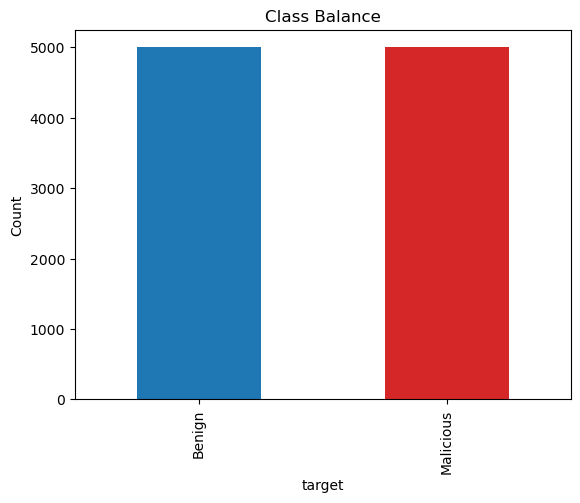

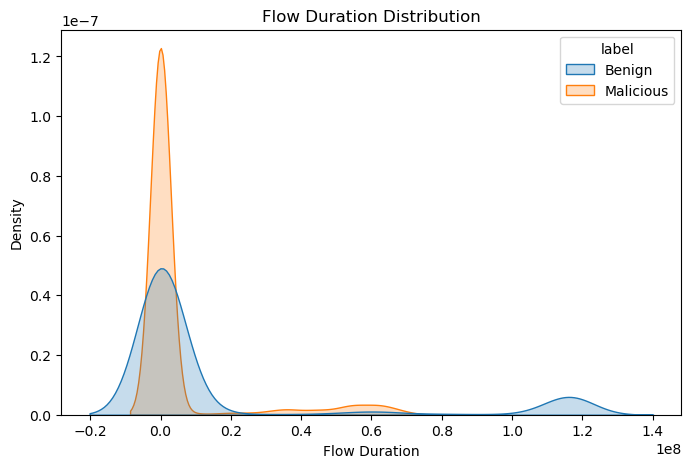

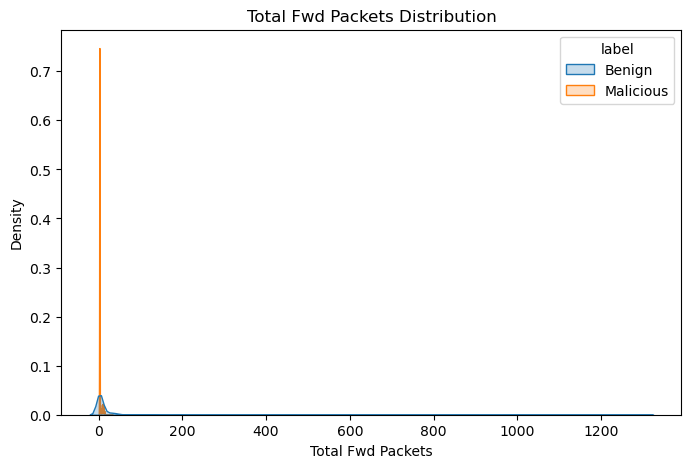

In [213]:
#Section 2A
df = pd.read_csv("q2.csv")  # load dataset

y = df["target"]                 # 1 = malicious, 0 = benign
X = df.drop(columns=["target"])  # feature matrix

categorical_cols = ["Protocol"]
numeric_cols = [col for col in X.columns if col != "Protocol"]

# preprocessing: scale numerics + one-hot protocol
preprocess = ColumnTransformer([
    ("scale", StandardScaler(), numeric_cols),
    ("onehot", OneHotEncoder(drop=None, sparse_output=False), 
     categorical_cols)
])

pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

summary = X.describe().T.round(2)
print(summary.to_string())

# class balance plot
label_map = {0: "Benign", 1: "Malicious"}
counts = y.value_counts().rename(index=label_map)

counts.plot.bar(title="Class Balance", color=["tab:blue", "tab:red"])
plt.ylabel("Count")
plt.show()
df["label"] = df["target"].map(label_map)
plt.figure(figsize=(8, 5)) # Flow Duration distribution
sns.kdeplot(data=df, x="Flow Duration", hue="label",
            fill=True, common_norm=False)
plt.title("Flow Duration Distribution")
plt.xlabel("Flow Duration")
plt.ylabel("Density")
plt.show()
plt.figure(figsize=(8, 5)) # Total Fwd Packets distribution
sns.kdeplot(data=df, x="Total Fwd Packets", hue="label",
            fill=True, common_norm=False)
plt.title("Total Fwd Packets Distribution")
plt.xlabel("Total Fwd Packets")
plt.ylabel("Density")
plt.show()

The class balance plot shows an even split between benign and malicious traffic, with five thousand samples in each class. This is helpful because it allows us to compare the two groups fairly. Since each class has the same number of examples, it is easier to analyse how their behaviour differs without one group dominating the dataset.

The feature summary table shows the scale and spread of the features. Many of the network flow features have very large ranges, such as Flow Duration and Idle Mean, while others have small ranges like Packet Length Mean. The wide variation highlights the importance of scaling the data before modelling.

The Flow Duration plot shows moderate separation between the two classes. Malicious flows tend to be very short, clustering near zero, while benign traffic displays a wider spread with some outliers. This indicates that cyber attackers often generate brief, fast interactions, while normal traffic includes both short and extended sessions. Although there is overlap near the origin, the heavier tail for benign flows provides a useful signal for classification.

The Total Forward Packets distribution shows stronger separation. Malicious flows tend to contain almost no forward packets, forming a sharp peak around one or two packets. Benign flows have a wider distribution, indicating a more sustained and varied packet exchange in the forward direction. This difference suggests that malicious flows often have small amounts of forward traffic. The clear contrast in distribution shapes makes this feature particularly useful for distinguishing the two classes.

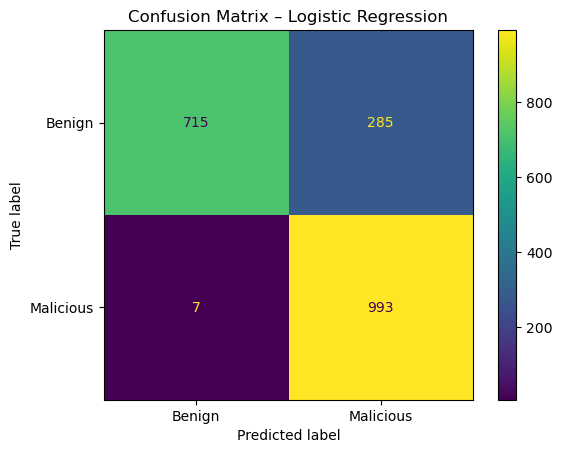

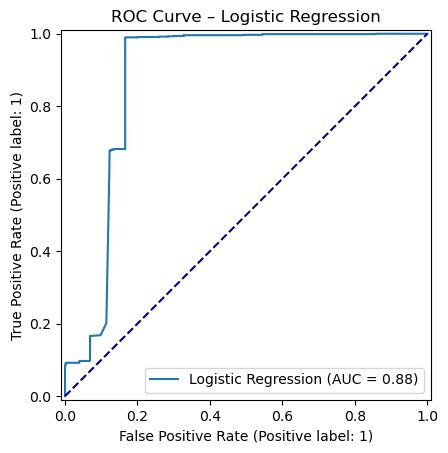

ROC-AUC: 0.8789495
Accuracy: 85.40%


In [215]:
# Section 2B

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=5000))
])

log_reg_pipeline.fit(X_train, y_train)  # train model

# Predictions
y_pred = log_reg_pipeline.predict(X_test)
y_prob = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malicious"])
disp.plot()
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob,
                                 name="Logistic Regression")
plt.plot([0, 1], [0, 1], '--', color='navy')
plt.title("ROC Curve – Logistic Regression")
plt.show()

# Metrics
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

The logistic regression model achieved an accuracy of 85.40%. This means that out of 100 test samples, 85 were correctly classified as either benign or malicious. The Accuracy gives a general understanding of performance, but it does not explain how the model performs on each class.

The confusion matrix reveals that the model accurately finds most malicious flows, with only 7 false negatives. This means that it rarely misses harmful traffic. However, it misclassifies a much larger number of benign flows as malicious, creating 285 false positives. This indicates that while the model is strong at detecting malicious activity, it tends to raise more false alarms for benign traffic.

The ROC curve shows how the model’s ability to detect malicious flows changes as the decision threshold changes. At each threshold, the true positive rate and false positive rate are computed, and the curve illustrates the trade-off. The ROC curve rises steeply toward the top left, meaning the model can achieve a high true positive rate while keeping the false positive rate relatively low for a range of thresholds. The model reaches a very high detection rate of malicious flows before the false positive rate increases sharply. The ROC-AUC score of about 0.88 indicates strong overall ranking ability, meaning the model assigns higher predicted probabilities to malicious flows than benign ones most of the time. A score of 1.0 would represent perfect class separation, while 0.5 would mean no discriminatory ability.

Although it tends to produce more false alarms on benign samples, the logistic regression model performs well overall, particularly when it comes to identifying malicious flows.

Best L1-logistic C: 100.0
Accuracy: 94.45%


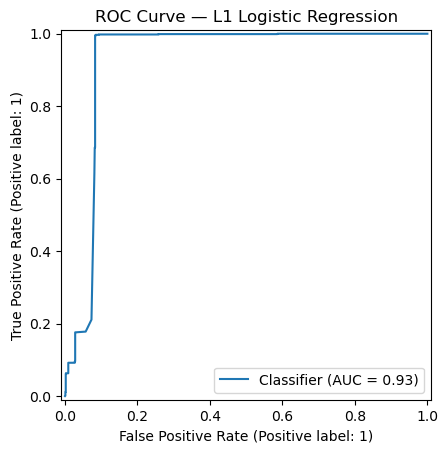

ROC-AUC: 0.9314
Bootstrap feature selection summary:


Feature  Selection Frequency  Mean Coef  Mean Abs Coef
0                 scale__Flow Duration                 1.00     -10.42          10.42
1             scale__Total Fwd Packets                 1.00      48.34          48.34
2        scale__Total Backward Packets                 1.00      -0.22           6.43
3   scale__Total Length of Fwd Packets                 1.00       1.35          29.05
4   scale__Total Length of Bwd Packets                 1.00    -136.98         136.98
5                 scale__Flow IAT Mean                 1.00       4.24           4.24
6                  scale__Flow IAT Std                 1.00      -3.02           3.21
7            scale__Packet Length Mean                 1.00      53.81          53.81
8             scale__Packet Length Std                 1.00    -240.91         240.91
9           scale__Average Packet Size                 1.00      17.13          18.35
10                  scale__Active Mean                 1.00      -1.38           1.38
11                    scale__Idle Mean                 1.00       3.60           3.60
12                  onehot__Protocol_0                 1.00     -93.20          93.20
13                  onehot__Protocol_6                 1.00     -26.00          26.00
14                 onehot__Protocol_17                 1.00    -374.50         374.50

/var/folders/40/41fj250s0671b6vxpm392x1h0000gn/T/ipykernel_47755/2627854750.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


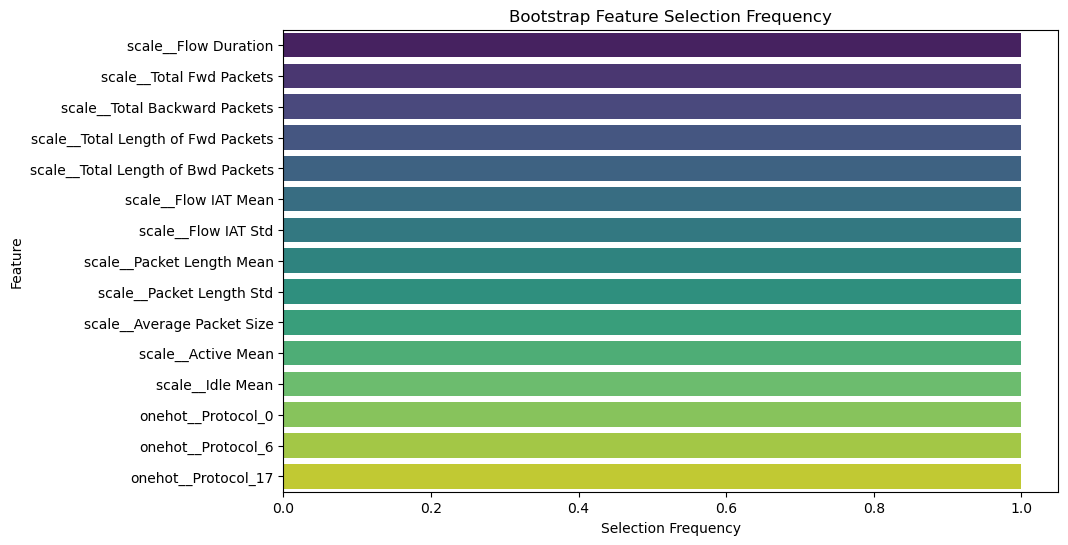

Top 5 most influential features:


Feature  Selection Frequency  Mean Abs Coef
14                 onehot__Protocol_17                 1.00         374.50
8             scale__Packet Length Std                 1.00         240.91
4   scale__Total Length of Bwd Packets                 1.00         136.98
12                  onehot__Protocol_0                 1.00          93.20
7            scale__Packet Length Mean                 1.00          53.81

/var/folders/40/41fj250s0671b6vxpm392x1h0000gn/T/ipykernel_47755/2627854750.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


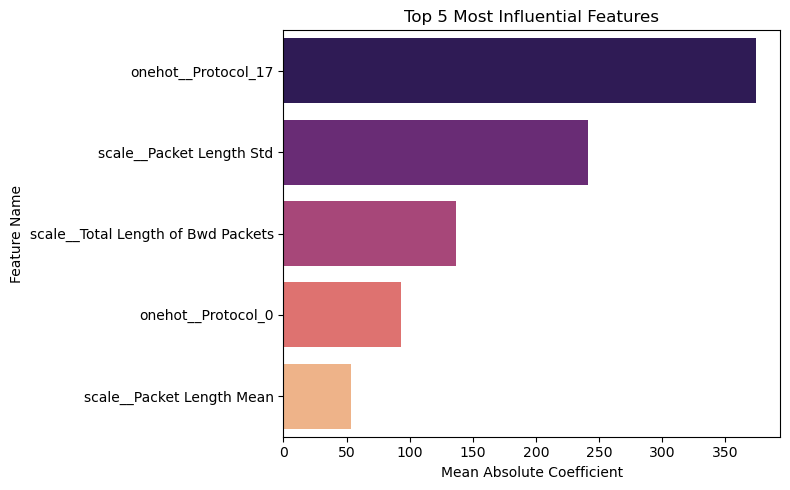

In [250]:
# Section 2C
base_l1_pipe = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=5000
    ))
])

# tune C using ROC-AUC optimisation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
C_grid = np.logspace(-3, 3, 7)
param_grid = {"logreg__C": C_grid}

log_l1_cv = GridSearchCV(
    estimator=base_l1_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

log_l1_cv.fit(X_train, y_train)
l1_log_reg = log_l1_cv.best_estimator_ # tuned L1 pipeline
best_C = log_l1_cv.best_params_["logreg__C"]
print("Best L1-logistic C:", best_C)

feature_names = (
    l1_log_reg
    .named_steps["preprocess"]
    .get_feature_names_out()
)
n_features = len(feature_names)

y_pred_l1 = l1_log_reg.predict(X_test) # class predictions
y_prob_l1 = l1_log_reg.predict_proba(X_test)[:, 1] # prob of malicious

acc_l1 = accuracy_score(y_test, y_pred_l1)
print(f"Accuracy: {acc_l1*100:.2f}%")  # Accuracy

RocCurveDisplay.from_predictions(y_test, y_prob_l1)
plt.title("ROC Curve — L1 Logistic Regression")
plt.show()

auc_l1 = roc_auc_score(y_test, y_prob_l1)
print(f"ROC-AUC: {auc_l1:.4f}")  # ROC-AUC

n_bootstraps = 20
selection_counts = np.zeros(n_features)
coef_matrix = [] # store bootstrap coefficients

for i in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, replace=True, 
                              random_state=42 + i)  # bootstrap sample

    l1_model = Pipeline([
        ("preprocess", preprocess),
        ("logreg", LogisticRegression(
            penalty="l1",
            solver="liblinear",
            C=best_C,
            max_iter=5000
        ))
    ])

    l1_model.fit(X_boot, y_boot)

    coefs = l1_model.named_steps["logreg"].coef_.ravel()
    selected = (coefs != 0).astype(int)

    selection_counts += selected
    coef_matrix.append(coefs)

coef_matrix = np.vstack(coef_matrix)

selection_freq = selection_counts / n_bootstraps
mean_coef = coef_matrix.mean(axis=0) # average coefficient
mean_abs_coef = np.abs(coef_matrix).mean(axis=0) # average influence size

feature_summary = pd.DataFrame({
    "Feature": feature_names,
    "Selection Frequency": selection_freq,
    "Mean Coef": mean_coef,
    "Mean Abs Coef": mean_abs_coef
}).sort_values("Selection Frequency", ascending=False)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 120)
pd.set_option("display.max_rows", 20)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")


print("Bootstrap feature selection summary:")
display(feature_summary)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_summary,
    x="Selection Frequency",
    y="Feature",
    palette="viridis"
)
plt.title("Bootstrap Feature Selection Frequency")
plt.xlabel("Selection Frequency")
plt.ylabel("Feature")
plt.show()

top5 = feature_summary.sort_values("Mean Abs Coef",
                                   ascending=False).head(5)
print("Top 5 most influential features:")
display(top5[["Feature", "Selection Frequency", "Mean Abs Coef"]])

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top5,
    x="Mean Abs Coef",
    y="Feature",
    palette="magma"
)
plt.title("Top 5 Most Influential Features")
plt.xlabel("Mean Absolute Coefficient")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


The top five most influential features clearly capture meaningful behavioural differences between benign and malicious traffic. The protocol indicators with large coefficients suggest that specific protocol values are much more common in malicious flows, making protocol type a strong signal for classification. Packet length values also play a major role, indicating that malicious flows often contain packets that are unusually large or vary more in size compared to benign traffic. Finally, the importance of backward packet length implies that the amount and structure of data sent back from the destination differs noticeably in malicious connections, helping separate the two classes.

The bootstrap results show that all features were selected in every resample, which means the model keeps finding all of them useful no matter how the training data is shuffled. This suggests the model’s choices are stable and not just random. The earlier summary table supports this because every feature had a non-zero mean absolute coefficient, showing that each one contributed something to the model’s decisions.

In [219]:
# Section 2D.1
# linear SVM
svc_cv_pipe = Pipeline([
    ("preprocess", preprocess),
    ("svm", LinearSVC(dual=False, max_iter=10000, random_state=0))
])
C_values = [0.1, 1, 10, 100]  # C grid to test
param_grid_svm = {"svm__C": C_values}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    estimator=svc_cv_pipe,
    param_grid=param_grid_svm,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
svm_grid.fit(X_train, y_train)  # run CV search
print("Linear SVC CV Results")
means = svm_grid.cv_results_["mean_test_score"]
params = svm_grid.cv_results_["params"]
for mean, p in zip(means, params):
    print(f"C = {p['svm__C']:>5}  -->  mean ROC-AUC = {mean:.4f}")

best_C_svm = svm_grid.best_params_["svm__C"]
print("Best C for soft-margin linear SVM:", best_C_svm)

Linear SVC CV Results
C =   0.1  -->  mean ROC-AUC = 0.8841
C =     1  -->  mean ROC-AUC = 0.9109
C =    10  -->  mean ROC-AUC = 0.9193
C =   100  -->  mean ROC-AUC = 0.9216
Best C for soft-margin linear SVM: 100



Soft-margin Linear SVM (SVC, C = 100)
  Test accuracy        : 0.942
  Test ROC-AUC         : 0.947
  # support vectors    : 1746


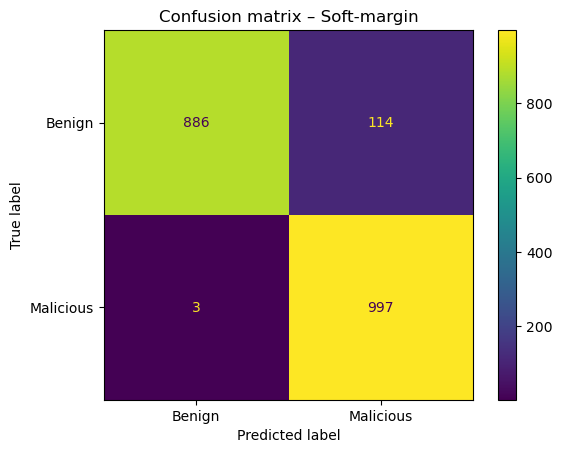

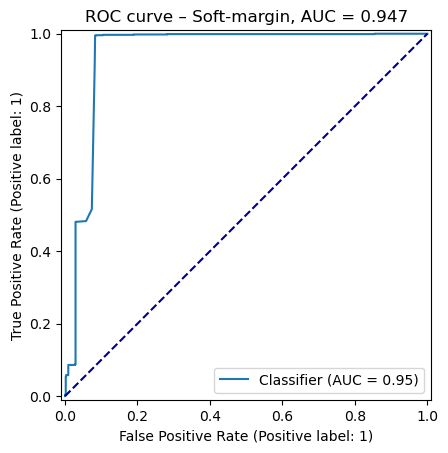

In [220]:
# 2D.2 – Soft-margin linear SVM 
soft_svm = Pipeline([
    ("preprocess", preprocess),
    ("svc", SVC(kernel="linear",
                C=best_C_svm,
                probability=False,
                max_iter=200000,
                random_state=0))
])
soft_svm.fit(X_train, y_train)

y_pred_soft = soft_svm.predict(X_test)
y_score_soft = soft_svm.decision_function(X_test)  # continuous scores

soft_acc = accuracy_score(y_test, y_pred_soft)
soft_auc = roc_auc_score(y_test, y_score_soft)
# SV count
soft_n_sv = soft_svm.named_steps["svc"].support_vectors_.shape[0]  

print(f"\nSoft-margin Linear SVM (SVC, C = {best_C_svm})")
print(f"  Test accuracy        : {soft_acc:.3f}")
print(f"  Test ROC-AUC         : {soft_auc:.3f}")
print(f"  # support vectors    : {soft_n_sv}")

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_soft,
    display_labels=["Benign", "Malicious"]
)
plt.title("Confusion matrix – Soft-margin")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_score_soft)
plt.plot([0, 1], [0, 1], '--', color='navy')
plt.title(f"ROC curve – Soft-margin, AUC = {soft_auc:.3f}")
plt.show()



Hard-margin Linear SVM (SVC, C = 1e+06)
  Test accuracy     : 0.712
  Test ROC-AUC      : 0.764
  # support vectors : 291


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


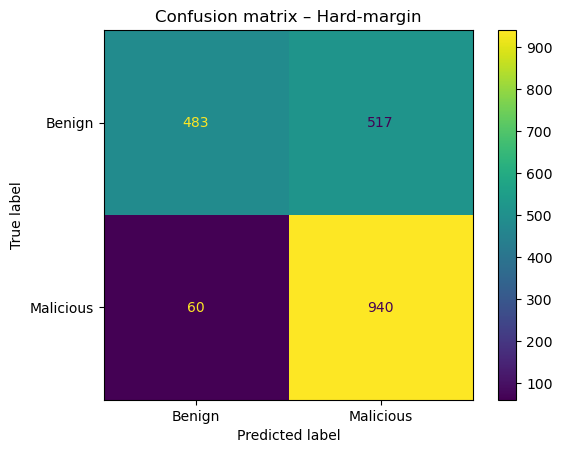

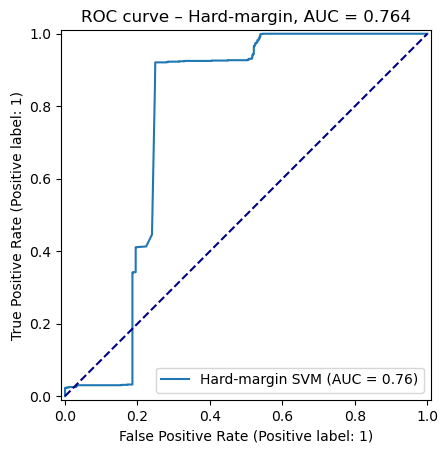

In [221]:
# 2D.3 – Hard-margin linear SVM
hard_C = 1e6  # Hard margin
hard_svm = Pipeline([
    ("preprocess", preprocess),
    ("svc", SVC(kernel="linear",
                C=hard_C,
                probability=False,
                max_iter=200000,
                random_state=0))
])
hard_svm.fit(X_train, y_train)  # train hard-margin model

# Predictions and decision scores
y_pred_hard = hard_svm.predict(X_test)
y_score_hard = hard_svm.decision_function(X_test)
hard_acc = accuracy_score(y_test, y_pred_hard)
hard_auc = roc_auc_score(y_test, y_score_hard)
# SV count
hard_n_sv = hard_svm.named_steps["svc"].support_vectors_.shape[0]  

print(f"\nHard-margin Linear SVM (SVC, C = {hard_C:.0e})")
print(f"  Test accuracy     : {hard_acc:.3f}")
print(f"  Test ROC-AUC      : {hard_auc:.3f}")
print(f"  # support vectors : {hard_n_sv}")

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_hard,
    display_labels=["Benign", "Malicious"]
)
plt.title("Confusion matrix – Hard-margin")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(
    y_test,
    y_score_hard,
    name="Hard-margin SVM"
)
plt.plot([0, 1], [0, 1], "--", color="navy")  # random classifier line
plt.title(f"ROC curve – Hard-margin, AUC = {hard_auc:.3f}")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


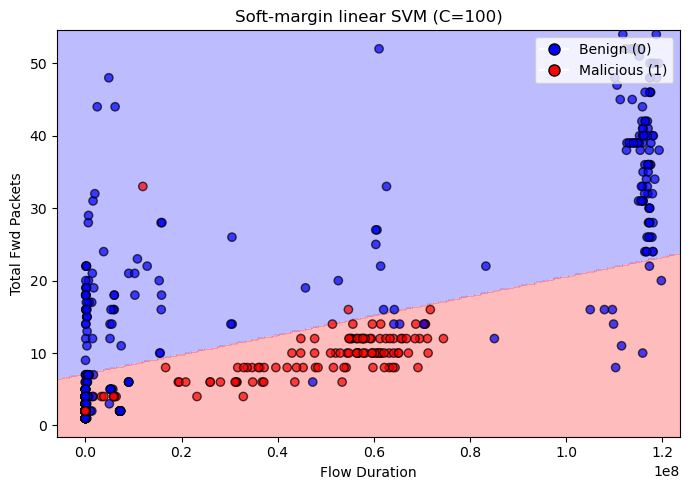

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


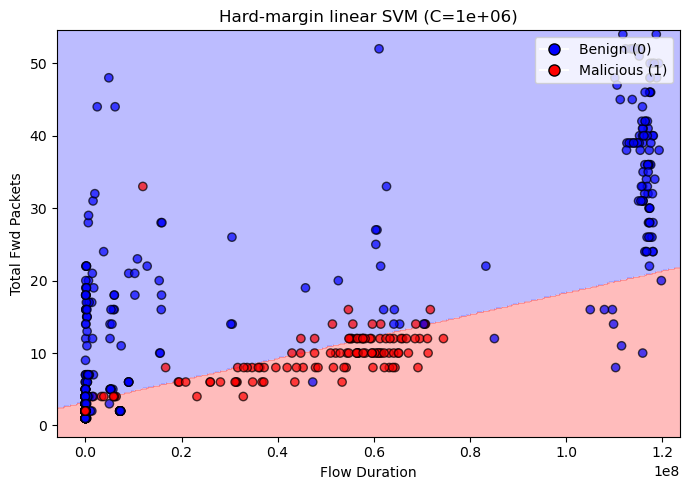

In [222]:
# 2D.4 – Decision boundaries
feat1 = "Flow Duration"
feat2 = "Total Fwd Packets"

Xtr = X_train[[feat1, feat2]].copy()
Xte = X_test[[feat1, feat2]].copy()

svm_soft = Pipeline([
    ("scale", StandardScaler()),
    ("svc", SVC(kernel="linear",
                C=best_C_svm,
                probability=False,
                random_state=0))
]).fit(Xtr, y_train)

svm_hard = Pipeline([
    ("scale", StandardScaler()),
    ("svm", LinearSVC(C=hard_C, dual=False,
                      max_iter=100000, random_state=0))
]).fit(Xtr, y_train)


def plot_boundary(model, X_plot, y_plot, feat1, feat2, title):
    x_min, x_max = np.percentile(X_plot[feat1], [1, 99])
    y_min, y_max = np.percentile(X_plot[feat2], [1, 99])

    # small padding
    x_pad = 0.05 * (x_max - x_min)
    y_pad = 0.05 * (y_max - y_min)
    x_min, x_max = x_min - x_pad, x_max + x_pad
    y_min, y_max = y_min - y_pad, y_max + y_pad

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")

    # Scatter points
    scatter = plt.scatter(
        X_plot[feat1],
        X_plot[feat2],
        c=y_plot,
        cmap="bwr",
        edgecolor="k",
        alpha=0.7
    )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', 
                   label='Benign (0)',
                   markerfacecolor='blue', markeredgecolor='k',
                   markersize=8),
        plt.Line2D([0], [0], marker='o', color='w',
                   label='Malicious (1)',
                   markerfacecolor='red', markeredgecolor='k', 
                   markersize=8)
    ]
    plt.legend(handles=handles, loc="upper right")

    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()


plot_boundary(
    svm_soft,
    Xte,
    y_test,
    feat1,
    feat2,
    f"Soft-margin linear SVM (C={best_C_svm})"
)

plot_boundary(
    svm_hard,
    Xte,
    y_test,
    feat1,
    feat2,
    f"Hard-margin linear SVM (C={hard_C:.0e})"
)

The cross-validation results for the linear SVM show a clear and steady improvement as the regularisation parameter C increases from 0.1 to 100, with ROC–AUC rising from 0.884 to 0.922. This shows that the data is not linearly separable, so the model performs better when mistakes are penalised more strongly. As C increases, the SVM is pushed to draw a boundary that fits the data more tightly, which helps it separate benign and malicious flows more effectively.

The soft-margin SVM with C = 100 performs well on the test set. It reaches 94.2% accuracy and a ROC–AUC of 0.947, and the confusion matrix shows that it correctly identifies almost all malicious flows while keeping false positives relatively low. The model uses 1,746 support vectors, which is expected for a dataset where the benign and malicious classes overlap. When many points sit close to the decision boundary, the classifier naturally relies on a large number of them to define the separating hyperplane. The ROC curve rises steeply near the y-axis, and in the 2D decision plot, the boundary is smooth, and mistakes cluster near the dividing line, reflecting a model that is separating the classes in a stable and consistent way.

The hard-margin SVM behaves very differently. Setting C to a very large value forces the model to try to separate all training points perfectly, even though the data is noisy and not linearly separable. As a result, the test performance is affected drastically: accuracy drops to 71.2% and ROC–AUC falls to 0.764. The confusion matrix shows a clear shift in behaviour. The hard-margin SVM still finds many malicious flows (940 true positives), but it also misses 60 of them and wrongly flags 517 benign flows as attacks. With only 483 correct benign classifications, the model ends up treating a large portion of normal traffic as malicious. This imbalance demonstrates how the hard-margin restriction distorts the boundary: instead of finding a balanced split, it drives the classifier toward over-predicting the positive class, leading to both greater false positives and a considerable rise in missing harmful samples. The number of support vectors also drops significantly to 291 because the hard-margin boundary becomes extremely wide and ends up covering most of the data. Once that happens, the majority of points lie far from the margin and no longer operate as support vectors. The ROC curve increases only marginally above the diagonal line, suggesting that the model struggles to discriminate malicious from benign flows across most thresholds. The same behaviour is shown in the 2D decision boundary plot, where a portion of the malicious points are on the wrong side of the boundary due to the separating line being pushed far into the malicious class, unlike the soft Margin SVM 2D plot that separates the classes much more adequately. The model effectively fails as a malicious traffic detector, despite the fact that it still generates a large number of true negatives.

A Hard-margin SVM is fragile in non-separable datasets because it assumes perfect separability. When the two classes overlap, the model cannot satisfy this strict constraint, which forces the decision boundary into an extreme, narrow position to accommodate the training points. This instability creates a boundary that is overly sensitive to outliers and fails to capture the true, underlying data distribution, causing the classifier to generalise poorly. Hence, the hard-margin SVM may generate a final boundary so wide that it only includes a very small number of points on the margin, resulting in a low support vector count, such as the observed 291 support vectors.

Best RBF SVM parameters:
  C     = 100
  gamma = 10
RBF SVM – test accuracy: 96.10%
RBF SVM – test ROC-AUC : 0.967
Number of support vectors (RBF SVM): 1521


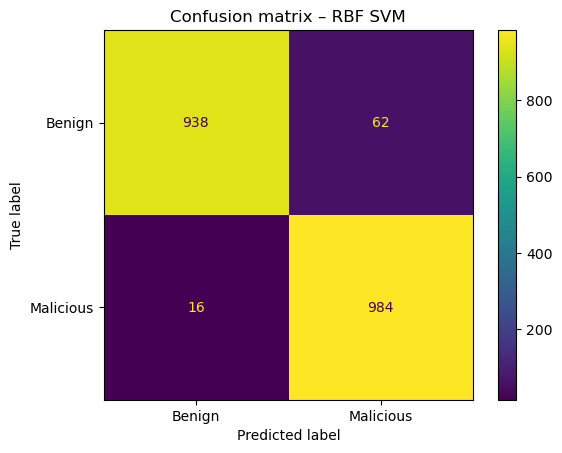

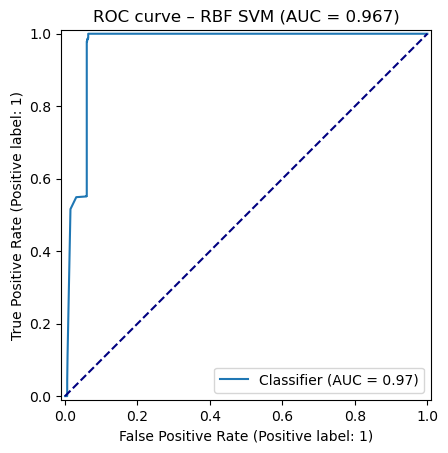


Model comparison (accuracy and ROC-AUC):
        Model  Accuracy  ROC_AUC
Logistic (L2)      0.85     0.88
  L1 logistic      0.94     0.93
      RBF SVM      0.96     0.97

Confusion-matrix summary:
        Model  TN  FP  FN  TP  TN_rate  FP_rate  FN_rate  TP_rate
Logistic (L2) 715 285   7 993     0.36     0.14     0.00     0.50
  L1 logistic 891 109   2 998     0.45     0.05     0.00     0.50
      RBF SVM 938  62  16 984     0.47     0.03     0.01     0.49


In [252]:
# Section 2E
rbf_cv_pipe = Pipeline([
    ("preprocess", preprocess),
    ("svc", SVC(kernel="rbf", probability=True, random_state=0))
])

C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.1, 1, 10]

param_grid_rbf = {"svc__C": C_values, "svc__gamma": gamma_values}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rbf_grid = GridSearchCV(
    estimator=rbf_cv_pipe,
    param_grid=param_grid_rbf,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

rbf_grid.fit(X_train, y_train)

best_C_rbf = rbf_grid.best_params_["svc__C"]
best_gamma_rbf = rbf_grid.best_params_["svc__gamma"]

print("Best RBF SVM parameters:")
print("  C     =", best_C_rbf)
print("  gamma =", best_gamma_rbf)

rbf_best = Pipeline([
    ("preprocess", preprocess),
    ("svc", SVC(kernel="rbf",
                C=best_C_rbf,
                gamma=best_gamma_rbf,
                probability=True,
                random_state=0))
])
rbf_best.fit(X_train, y_train)

y_pred_rbf = rbf_best.predict(X_test) # Predictions
y_prob_rbf = rbf_best.predict_proba(X_test)[:, 1]

acc_rbf = accuracy_score(y_test, y_pred_rbf)
auc_rbf = roc_auc_score(y_test, y_prob_rbf)

print(f"RBF SVM – test accuracy: {acc_rbf*100:.2f}%")
print(f"RBF SVM – test ROC-AUC : {auc_rbf:.3f}")

n_sv_rbf = rbf_best.named_steps["svc"].support_vectors_.shape[0]
print(f"Number of support vectors (RBF SVM): {n_sv_rbf}")


ConfusionMatrixDisplay.from_predictions( # Confusion matrix
    y_test,
    y_pred_rbf,
    display_labels=["Benign", "Malicious"]
)
plt.title("Confusion matrix – RBF SVM")
plt.show()


RocCurveDisplay.from_predictions(y_test, y_prob_rbf) # ROC curve
plt.plot([0, 1], [0, 1], '--', color='navy')   # random classifier
plt.title(f"ROC curve – RBF SVM (AUC = {auc_rbf:.3f})")
plt.show()

y_pred_log = log_reg_pipeline.predict(X_test) # Comparison with logistic models
y_prob_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_prob_log)

y_pred_l1 = l1_log_reg.predict(X_test)
y_prob_l1 = l1_log_reg.predict_proba(X_test)[:, 1]

acc_l1 = accuracy_score(y_test, y_pred_l1)
auc_l1 = roc_auc_score(y_test, y_prob_l1)

summary = pd.DataFrame({
    "Model": ["Logistic (L2)", "L1 logistic", "RBF SVM"],
    "Accuracy": [acc_log, acc_l1, acc_rbf],
    "ROC_AUC": [auc_log, auc_l1, auc_rbf]
})

print("\nModel comparison (accuracy and ROC-AUC):")
print(summary.to_string(index=False))



def confusion_stats(y_true, y_pred, name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total = tn + fp + fn + tp
    return {
        "Model": name,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "TN_rate": tn / total,
        "FP_rate": fp / total,
        "FN_rate": fn / total,
        "TP_rate": tp / total
    }

rows = [
    confusion_stats(y_test, y_pred_log, "Logistic (L2)"),
    confusion_stats(y_test, y_pred_l1, "L1 logistic"),
    confusion_stats(y_test, y_pred_rbf, "RBF SVM")
]

conf_table = pd.DataFrame(rows)
print("\nConfusion-matrix summary:")
print(conf_table.to_string(index=False))


The RBF-kernel SVM performs best out of the three models. It achieves 96% accuracy and a ROC-AUC of 0.97, which is higher than both the logistic regression (85%, AUC = 0.88) and the penalised logistic model (94%, AUC = 0.93). This improvement also appears in the confusion-matrix results. Logistic regression has 285 false positives and 7 false negatives, which suggests its linear decision boundary cannot handle the data’s complexity. The penalised logistic model lowers false positives to 109 and false negatives to 2, but it still does not match the flexibility of the RBF kernel.

The RBF SVM separates the data most clearly, with 62 false positives and 16 false negatives, and it has the highest true positive and true negative counts of all the models. Its false-positive rate is about 3%, which is lower than the other models, but still higher than the penalised logistic regression and the soft-margin linear SVM, which are closer to 1%. However, the RBF SVM makes up for this with much stronger true-positive results, leading to the best accuracy and highest ROC-AUC score. These findings suggest the data is not linearly separable, and the RBF kernel’s ability to learn curved, nonlinear boundaries gives it a clear edge over the linear models.

N_pos (malicious) = 1000
N_neg (benign)    = 1000

 Logistic regression
Default threshold: t = 0.5
Confusion matrix:
[[715 285]
 [  7 993]]
Expected cost at default threshold: £7,285,000

Optimal threshold from cost curve: t* = 0.0000
Minimum expected cost: £858,000

 L1 logistic regression
Default threshold: t = 0.5
Confusion matrix:
[[891 109]
 [  3 997]]
Expected cost at default threshold: £3,109,000

Optimal threshold from cost curve: t* = 0.0000
Minimum expected cost: £588,000

 Linear SVM (soft margin)
Default threshold: t = 0.5
Confusion matrix:
[[900 100]
 [  4 996]]
Expected cost at default threshold: £4,100,000

Optimal threshold from cost curve: t* = 0.0000
Minimum expected cost: £854,000

 RBF SVM
Default threshold: t = 0.5
Confusion matrix:
[[938  62]
 [ 16 984]]
Expected cost at default threshold: £16,062,000

Optimal threshold from cost curve: t* = 0.0787
Minimum expected cost: £64,000


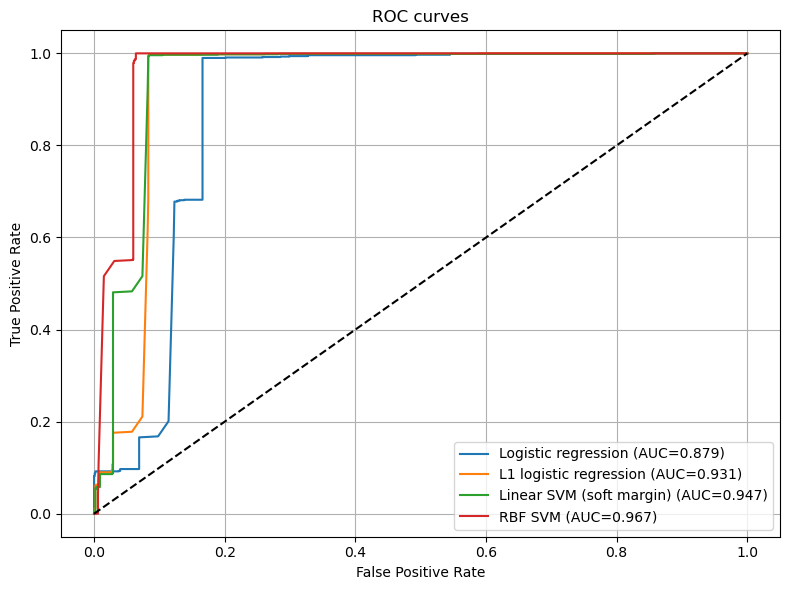

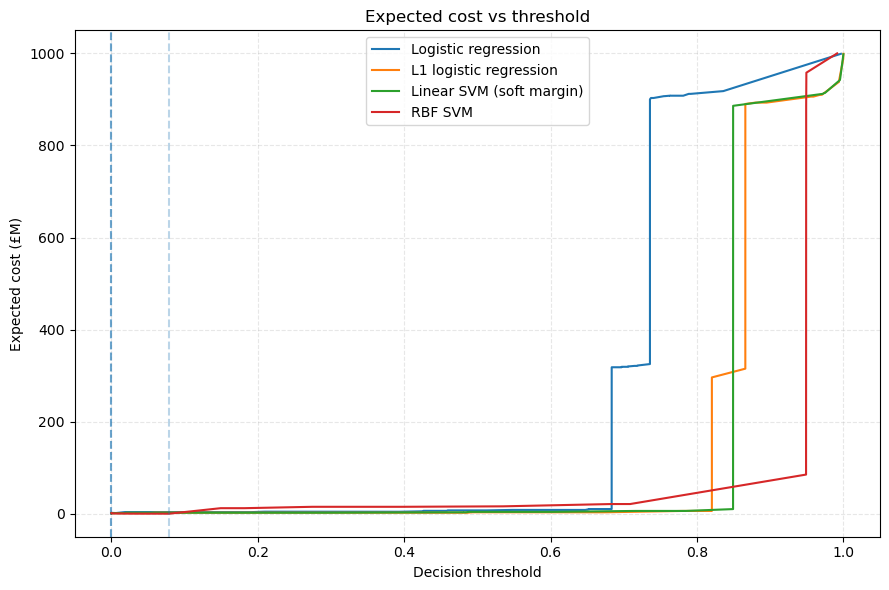


Performance Summary:
                   Model  Default t  TN  FP  FN  TP  Accuracy
     Logistic regression       0.50 715 285   7 993      0.85
  L1 logistic regression       0.50 891 109   3 997      0.94
Linear SVM (soft margin)       0.50 900 100   4 996      0.95
                 RBF SVM       0.50 938  62  16 984      0.96

Cost Summary:
                   Model  Default cost (£)  Optimal t*  Min cost (£)
     Logistic regression           7285000        0.00     858000.00
  L1 logistic regression           3109000        0.00     588000.00
Linear SVM (soft margin)           4100000        0.00     854000.00
                 RBF SVM          16062000        0.08      64000.00


In [248]:
# Section 2F – Cost-sensitive scenario
C_FN = 1000000    # false negative cost (£1M)
C_FP = 1000       # false positive cost (£1k)
N_pos = np.sum(y_test == 1)      # number of malicious in test
N_neg = np.sum(y_test == 0)      # number of benign in test
print("N_pos (malicious) =", N_pos)
print("N_neg (benign)    =", N_neg)

# Platt scaling for soft-margin SVM to get probabilities
soft_train_scores = soft_svm.decision_function(X_train).reshape(-1, 1) 
svm_calib = LogisticRegression(solver="lbfgs", max_iter=1000)
svm_calib.fit(soft_train_scores, y_train)  # calibrate SVM scores

def get_scores(model, X, probability=True):
    if probability and hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        return model.decision_function(X)
    
def expected_cost_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    return C_FN*fn + C_FP*fp  # weighted cost
    
def analyse_model(name, model, X_test, y_test, default_threshold=0.5,
                  use_probability=True):
    print(f"\n {name}")
    scores = get_scores(model, X_test, probability=use_probability)
    
    if name == "Linear SVM (soft margin)":
        raw_scores = soft_svm.decision_function(X_test).reshape(-1, 1)
        scores = svm_calib.predict_proba(raw_scores)[:, 1]
        
    y_pred_default = (scores >= default_threshold).astype(int)
    cm_default = confusion_matrix(y_test, y_pred_default)
    cost_default = expected_cost_from_cm(cm_default)
    print(f"Default threshold: t = {default_threshold}")
    print("Confusion matrix:")
    print(cm_default)
    print(f"Expected cost at default threshold: £{cost_default:,.0f}")
    
    # ROC-based cost curve
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    fnr = 1 - tpr
    costs = C_FN*fnr*N_pos + C_FP*fpr*N_neg  # cost at every threshold
    idx_best = np.argmin(costs)
    best_t = thresholds[idx_best]
    best_cost = costs[idx_best]
    print(f"\nOptimal threshold from cost curve: t* = {best_t:.4f}")
    print(f"Minimum expected cost: £{best_cost:,.0f}")
    auc_val = roc_auc_score(y_test, scores)
    return {
        "model": name,
        "default_t": default_threshold,
        "default_cost": cost_default,
        "best_t": best_t,
        "best_cost": best_cost,
        "cm": cm_default,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "costs": costs,
        "auc": auc_val
    }

results = []
results.append(analyse_model("Logistic regression", 
                             log_reg_pipeline, X_test, y_test))
results.append(analyse_model("L1 logistic regression",
                             l1_log_reg, X_test, y_test))
results.append(analyse_model("Linear SVM (soft margin)",
                             soft_svm, X_test, y_test,
                             use_probability=False))
results.append(analyse_model("RBF SVM", rbf_best,
                             X_test, y_test))

plt.figure(figsize=(8, 6)) # Plot ROC curves
for r in results:
    plt.plot(r["fpr"], r["tpr"],
             label=f"{r['model']} (AUC={r['auc']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6)) # Plot cost vs threshold curves
for r in results:
    thr = np.array(r["thresholds"])
    cost = np.array(r["costs"]) / 1e6             
    order = np.argsort(thr)                        
    plt.plot(thr[order], cost[order], label=r["model"])
    plt.axvline(r["best_t"], linestyle="--", alpha=0.3)

plt.xlabel("Decision threshold")
plt.ylabel("Expected cost (£M)")
plt.title("Expected cost vs threshold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

rows = [] # Summary table
N_test = len(y_test)
for r in results:
    tn, fp, fn, tp = r["cm"].ravel()
    acc = (tn + tp) / N_test   
    rows.append({
        "Model": r["model"],
        "Default t": r["default_t"],
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Accuracy": acc,
        "Default cost (£)": r["default_cost"],
        "Optimal t*": r["best_t"],
        "Min cost (£)": r["best_cost"],
    })

cost_summary = pd.DataFrame(rows)
# Table 1: Confusion-matrix-based metrics
table_perf = cost_summary[[
    "Model", "Default t", "TN", "FP", "FN", "TP", "Accuracy"
]]

print("\nPerformance Summary:")
print(table_perf.to_string(index=False))


# Table 2: Cost metrics
table_cost = cost_summary[[
    "Model", "Default cost (£)", "Optimal t*", "Min cost (£)"
]]

print("\nCost Summary:")
print(table_cost.to_string(index=False))


In this case, each false negative costs £1,000,000 while each false positive costs only £1,000, and the test set has 1,000 malicious and 1,000 benign flows. At the default threshold of 0.5 the RBF SVM has the best accuracy but actually gives the worst expected cost: about £16.06M from 16 FN and 62 FP. The linear models make fewer false negatives at 0.5, so their costs are lower even though their accuracies are worse: logistic regression costs about £7.29M (7 FN, 285 FP), L1 logistic about £2.11M (2 FN, 109 FP), and the soft margin SVM about £4.10M (4 FN, 100 FP). This shows that when false negatives are extremely expensive, raw accuracy and ROC alone are not enough to judge performance.

Once I change the thresholds to minimise expected cost, a large shift in the cost occurs. For the three linear models, the optimal threshold collapses essentially to zero, meaning the cheapest strategy is to predict “malicious” almost always so that false negatives disappear, accepting a large number of cheap false positives. In contrast, the RBF SVM achieves its minimum cost at a threshold around 0.079, and reaches an expected cost of only £64k. This very low cost means the RBF SVM can push the false negative rate close to zero while keeping the false positive rate relatively small, due to its stronger ability to separate the classes across all thresholds, as shown in the ROC curve.

Overall, after tuning the threshold to find the most optimal cost-effective model, the RBF SVM is clearly the best fit for this task. It is the only classifier that can achieve almost perfect detection of malicious flows without needing to label nearly everything as malicious, which keeps the number of false alarms low and drives the total expected cost far below the linear models.

### **2G Reflection**

### **1. Model Comparison**

**Interpretability:**

Logistic Regression models are the most interpretable. L1 bootstrapping confirms stable influence as all features were selected in all 20 resamples. The Linear SVM retains weight vector interpretability, but many support vectors and no probability output are drawbacks. The RBF SVM is the least interpretable, using non-linear kernels and basing decisions on similarity to over 1,500 complex support vectors.

**Accuracy:**

The RBF SVM achieved the highest accuracy (96%), followed by soft-margin (95%) and penalised logistic regression (94%). RBF has the lowest False Positives (62) but the highest False Negatives (16). Penalised Logistic Regression is superior at avoiding False Negatives (only 2 FNs). Overall, RBF identifies benign traffic best, but penalised logistic regression prevents missed attacks most reliably.

**Stability Under Resampling:**

Penalised Logistic Regression is the most stable, with all features selected across all 20 resamples. Logistic Regression is also stable due to robust coefficients. The Soft-Margin SVM is moderately stable (1,746 support vectors). The RBF SVM is less stable due to its nonlinear boundary. The Hard-Margin SVM is the least stable, with 291 support vectors, making its boundary highly sensitive to noise.

**Robustness to Changing Costs:**

Linear models are the most robust to changing costs because their performance shifts only slightly when the threshold is adjusted, whereas the RBF SVM is highly sensitive and only performs well once carefully re-thresholded. Its expected cost dropped by over 99% when moving from the default £16.06M to £64k, showing that it behaves poorly under standard settings and depends heavily on precise threshold tuning.

### **2. Deployment Recommendation**

I recommend a deployment strategy balancing explainability with detection power.

For baseline monitoring, penalised logistic regression is the most suitable primary detector. It is interpretable and stable, with coefficients clearly highlighting features that signal malicious traffic. This ensures decisions are transparent to analysts.

To complement this, the RBF SVM should be used as an escalation layer. The RBF model offers the strongest detection performance and lowest cost once its threshold is properly tuned, making it ideal as a high-precision secondary check rather than the first line of defence. For both components, thresholds must be set via cost-based optimisation (not the default 0.5) with regular monitoring for change. This approach keeps routine decisions clear while utilising the RBF SVM's superior detection power when most valuable.

### **3. Risks and Adaptation**

If new attack types shift the feature distribution, each model faces risk, with vulnerabilities tied to its assumptions. Logistic and Penalised-logistic are most exposed because they rely on linear relationships that may no longer hold. Linear SVMs face similar issues, as their fixed boundary can lose effectiveness after a shift in data. The RBF SVM is more adaptable, since its nonlinear boundary handles complex patterns, but it can still struggle if new attacks fall in regions far from the training data. To reduce these risks, the system should routinely check for data changes, retrain models when necessary, and update thresholds over time so the detection pipeline stays aligned with evolving attack behaviour.